In [33]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from wordcloud import WordCloud

# Load Dataset


In [34]:
with open('../data/02_document_search_results.json') as f:
    unique_docs = json.load(f)


# Summary of Subject Areas
Summarize the subject areas of the articles retrieved from the search results.

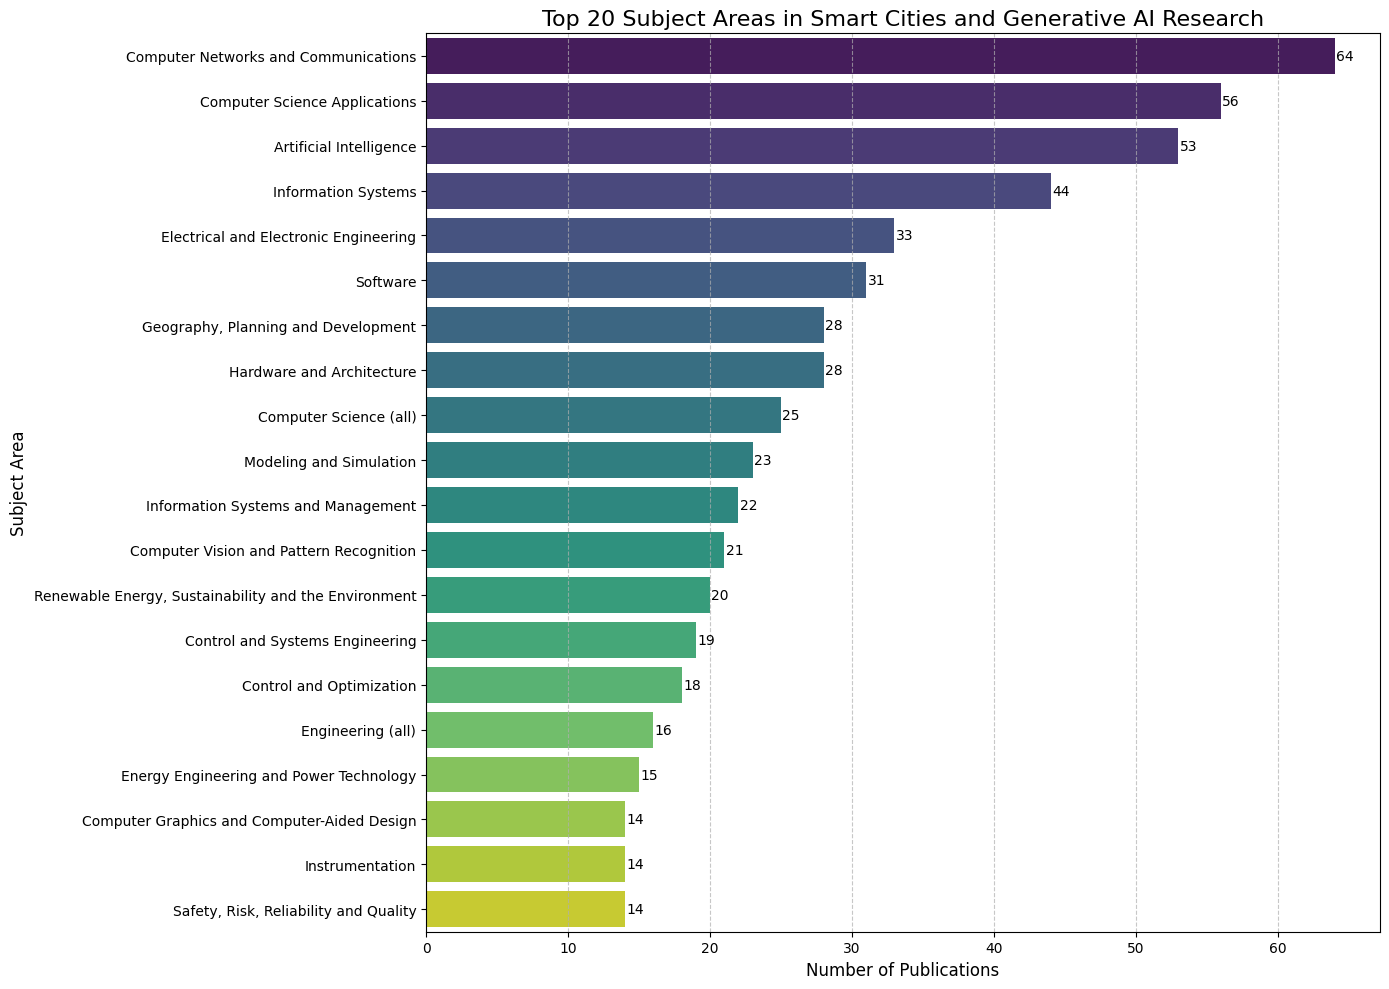



Performing correlation analysis between subject areas...


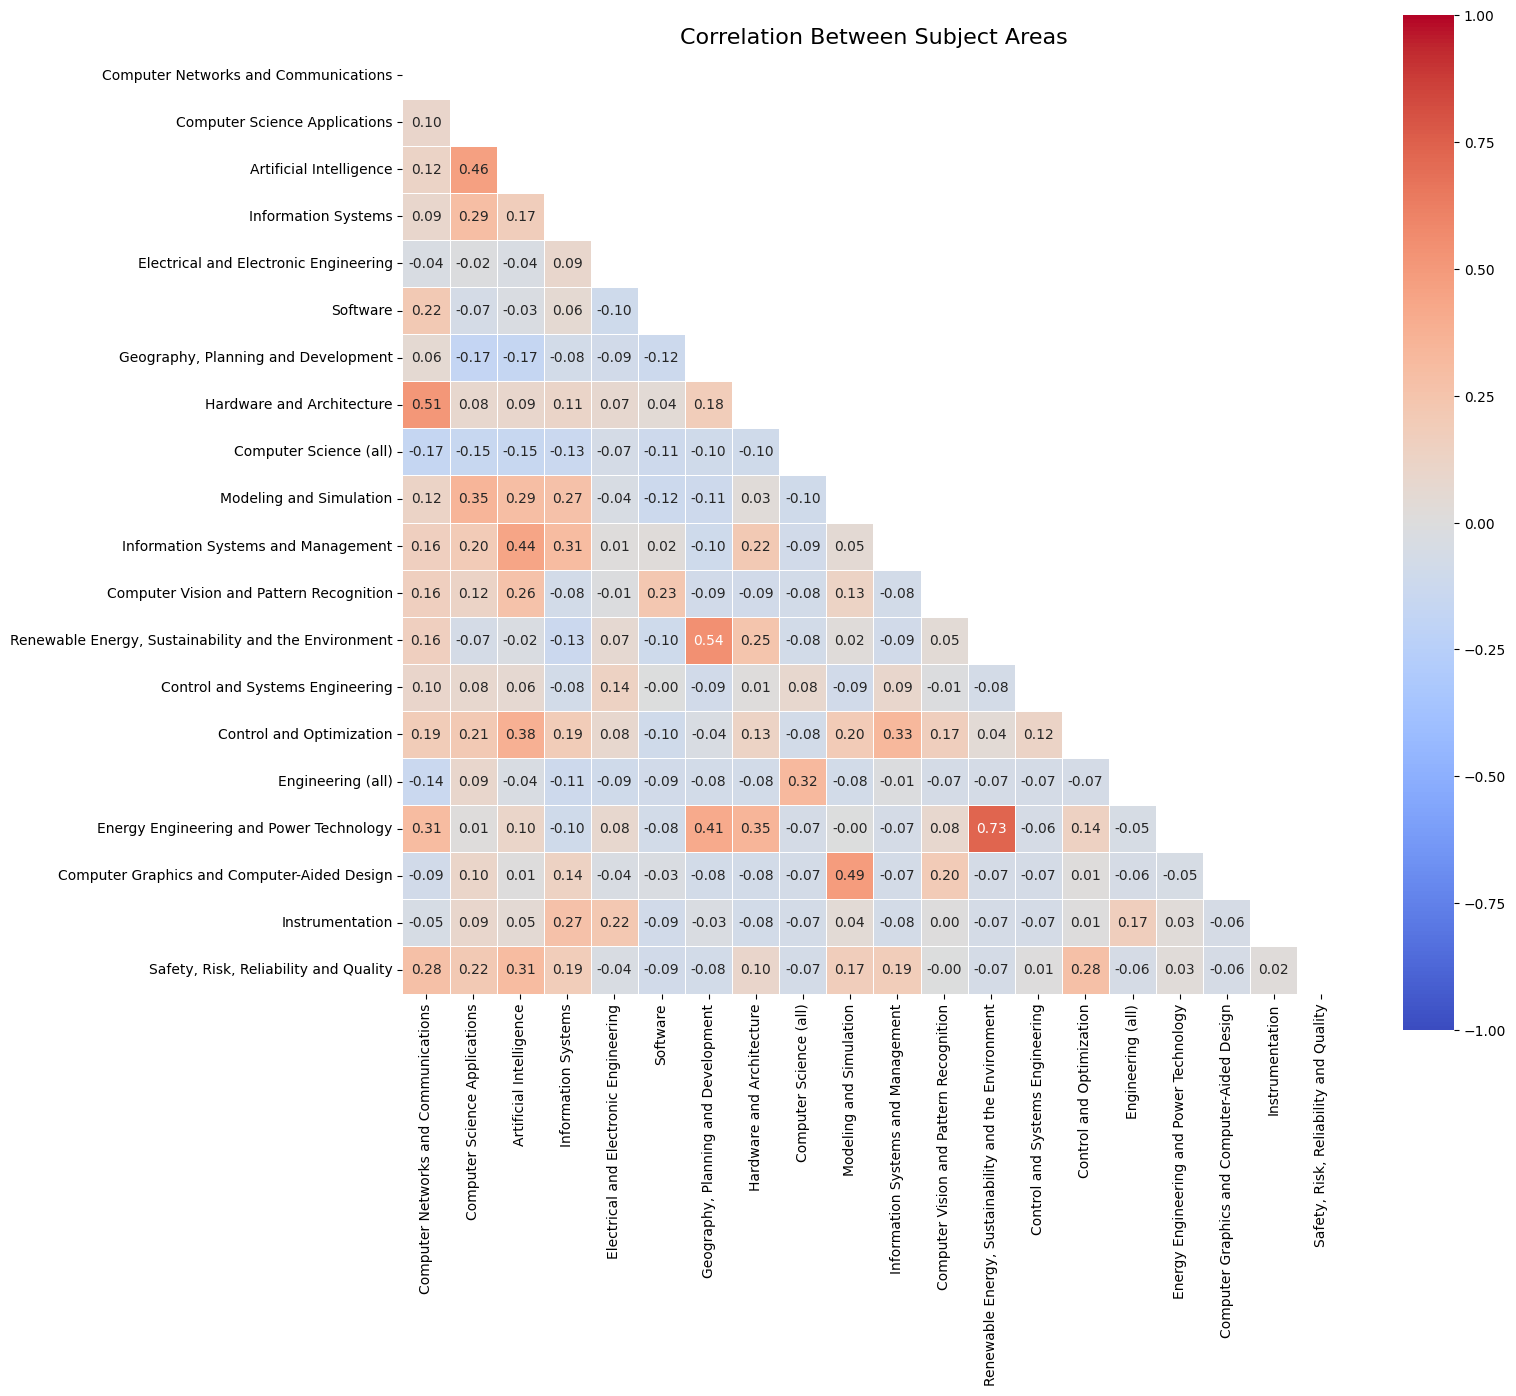


Subject Area Analysis Summary:
Total unique subject areas: 104
Documents with subject area information: 243 out of 269
Average subject areas per document: 3.57

Top 5 most common subject area pairs:
30 - Artificial Intelligence & Computer Science Applications
24 - Computer Networks and Communications & Hardware and Architecture
20 - Computer Science Applications & Information Systems
18 - Computer Networks and Communications & Computer Science Applications
18 - Artificial Intelligence & Computer Networks and Communications


In [35]:
# 1. Extract all subject areas
all_subject_areas = []
subject_area_by_doc = {}

# Iterate through documents to gather subject areas
for i, doc in enumerate(unique_docs):
    if "subject_areas" in doc and doc["subject_areas"]:
        subject_areas = doc["subject_areas"]
        # Store for correlation analysis
        subject_area_by_doc[i] = subject_areas
        # Add to overall list
        all_subject_areas.extend(subject_areas)
        
# Structure the subject areas and save to a file
with open('../data/03_subject_areas.json', 'w') as f:
    json.dump(all_subject_areas, f, indent=2, sort_keys=True)

# Count frequency of each subject area
subject_counts = Counter(all_subject_areas)

# Get top 20 subject areas by frequency
top_subject_areas = subject_counts.most_common(20)

# Create a DataFrame for plotting
df_subjects = pd.DataFrame(top_subject_areas, columns=["Subject Area", "Count"])

# Set up the figure with a larger size
plt.figure(figsize=(14, 10))

# Create a horizontal bar chart
ax = sns.barplot(
    x="Count",
    y="Subject Area",
    hue="Subject Area",
    data=df_subjects,
    palette="viridis",
    legend=False
)

# Customize the plot
plt.title(
    "Top 20 Subject Areas in Smart Cities and Generative AI Research", fontsize=16
)
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Subject Area", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add counts at the end of each bar
for i, v in enumerate(df_subjects["Count"]):
    ax.text(v + 0.1, i, str(v), va="center")

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# 2. Subject Area Correlation Analysis
print("\n\nPerforming correlation analysis between subject areas...")

# Create a correlation matrix between subject areas
# First, get unique subject areas from the top 20
unique_areas = [area for area, _ in top_subject_areas]

# Create a document-subject area matrix
doc_subject_matrix = pd.DataFrame(
    0, index=range(len(subject_area_by_doc)), columns=unique_areas
)

# Fill the matrix with 1 where a document has that subject area
for doc_idx, areas in subject_area_by_doc.items():
    for area in areas:
        if area in unique_areas:
            doc_subject_matrix.loc[doc_idx, area] = 1

# Calculate correlation matrix
correlation_matrix = doc_subject_matrix.corr()

# Set up the correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    mask=mask,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
)

plt.title("Correlation Between Subject Areas", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Print summary statistics
print("\nSubject Area Analysis Summary:")
print(f"Total unique subject areas: {len(subject_counts)}")
print(
    f"Documents with subject area information: {len(subject_area_by_doc)} out of {len(unique_docs)}"
)

# Calculate average number of subject areas per document
areas_per_doc = [len(areas) for areas in subject_area_by_doc.values()]
print(
    f"Average subject areas per document: {sum(areas_per_doc)/len(areas_per_doc):.2f}"
)

# Find most common subject area combinations
print("\nTop 5 most common subject area pairs:")
pair_counts = Counter()
for areas in subject_area_by_doc.values():
    for pair in combinations(sorted(areas), 2):
        pair_counts[pair] += 1

for pair, count in pair_counts.most_common(5):
    print(f"{count:2d} - {pair[0]} & {pair[1]}")

In [683]:
import re

# Load the patterns from JSON
with open("../data/keywords_regex.json", "r") as f:
    patterns = json.load(f)

# Add this after loading the JSON to debug patterns
for key, value in patterns.items():
    pattern = value["pattern"]
    try:
        re.compile(pattern)
    except re.error as e:
        print(f"\nError in pattern: {key}")
        print(f"Pattern: {pattern}")
        print(f"Error: {str(e)}")

# Convert to regex mapping dictionary
regex_mapping = {re.compile(p["pattern"]): p["replacement"] for p in patterns.values()}

# Function to normalize keywords using regex
def normalize_keyword_regex(keyword):
    # keyword = keyword.lower().strip()
    keyword = re.sub(r"[^\w\s]", " ", keyword)
    keyword = re.sub(r"\s+", " ", keyword)
    for pattern, replacement in regex_mapping.items():
        if re.search(pattern, keyword):
            return replacement
    return keyword  # return the keyword unchanged if no match

Total unique keywords after normalization: 610


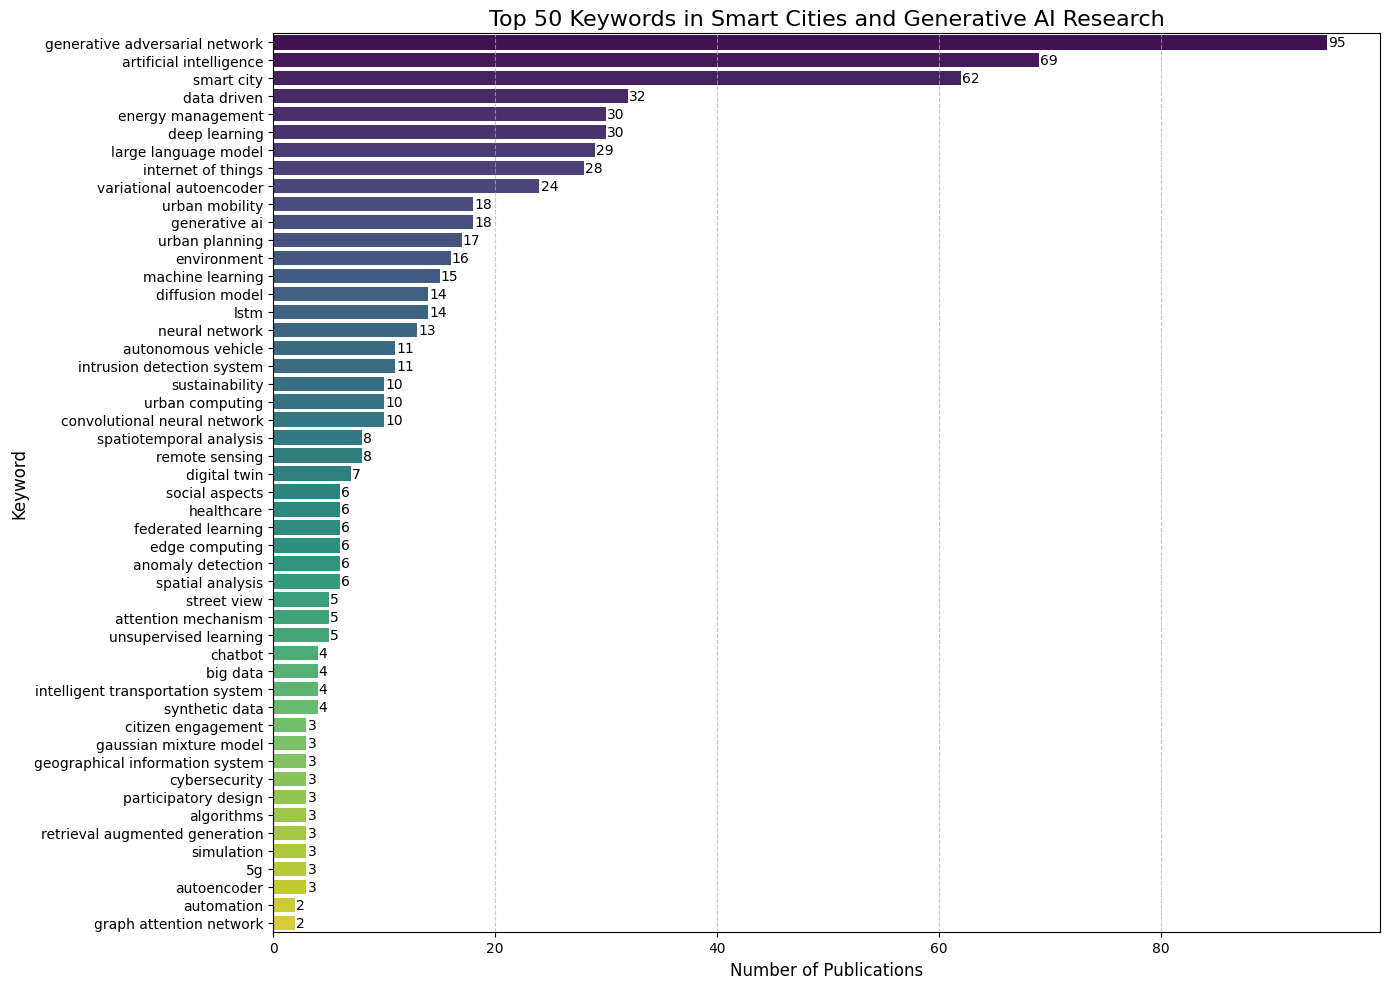

In [685]:
# 1. Extract all keywords with normalization
all_keywords = []
keywords_by_doc = {}
keyword_to_articles = {}

# Iterate through documents to gather keywords
for i, doc in enumerate(unique_docs):
    if "author_keywords" in doc and doc["author_keywords"]:
        # Clean, normalize keywords and group acronyms
        keywords = []
        for kw in doc["author_keywords"]:
            kw_lower = kw.lower().strip()
            normalized_kw = normalize_keyword_regex(kw_lower)
            keywords.append(normalized_kw)
        # keywords = doc["author_keywords"];

        # Store for correlation analysis
        keywords_by_doc[i] = keywords

        # Add to overall list
        all_keywords.extend(keywords)

        # Track which articles contain each keyword
        for kw in keywords:
            if kw not in keyword_to_articles:
                keyword_to_articles[kw] = []
            keyword_to_articles[kw].append(doc["title"])

# Count frequency of each keyword
keyword_counts = Counter(all_keywords)

print(f"Total unique keywords after normalization: {len(keyword_counts)}")

with open("../data/04_author_keywords_normalized.json", "w") as f:
    json.dump(keyword_counts, f, indent=2, sort_keys=True)

# Get top 50 keywords by frequency
top_keywords = keyword_counts.most_common(50)

# Create a DataFrame for plotting
df_keywords = pd.DataFrame(top_keywords, columns=["Keyword", "Count"])

# Set up the figure with a larger size
plt.figure(figsize=(14, 10))

# Create a horizontal bar chart
ax = sns.barplot(
    x="Count", 
    y="Keyword", 
    data=df_keywords, 
    hue="Keyword", 
    palette="viridis", 
    dodge=False,
    legend=False
)

# Customize the plot
plt.title("Top 50 Keywords in Smart Cities and Generative AI Research", fontsize=16)
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Keyword", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add counts at the end of each bar
for i, v in enumerate(df_keywords["Count"]):
    ax.text(v + 0.1, i, str(v), va="center")

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

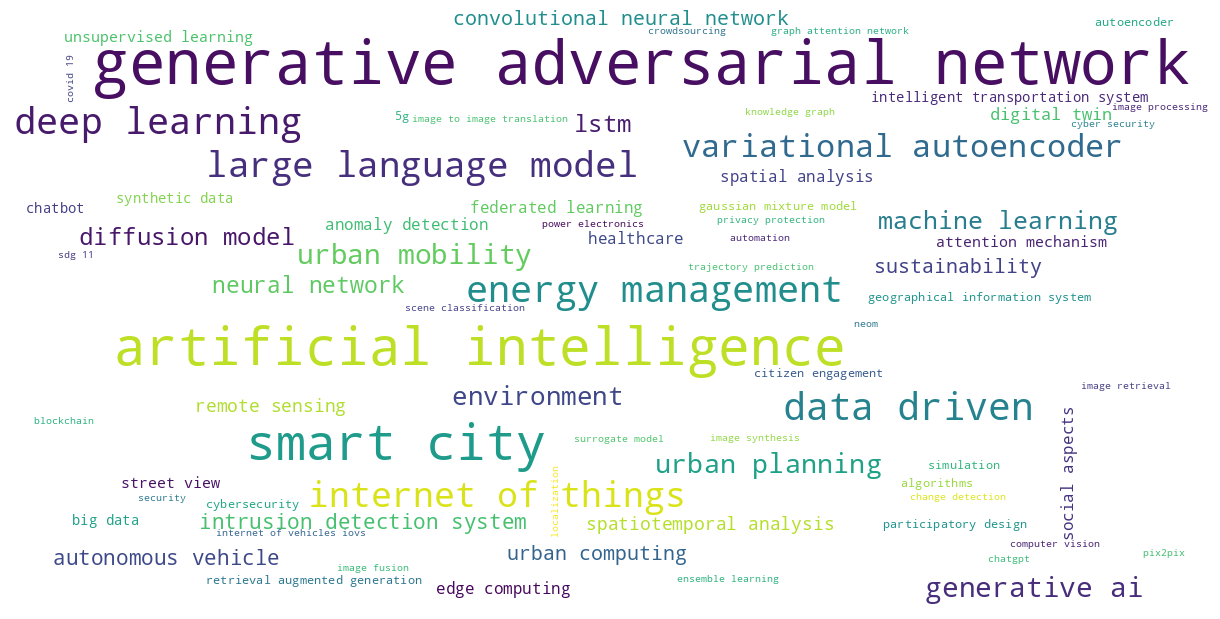

In [690]:
# 2. Generate Word Cloud for visual representation
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=100,
    colormap="viridis",
    min_font_size=10,
).generate_from_frequencies(keyword_counts)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Convert to DataFrame for easier manipulation
df_keywords = pd.DataFrame.from_dict(keyword_counts, orient="index", columns=["count"])
df_keywords = df_keywords.sort_values("count", ascending=False)
df_keywords = df_keywords.reset_index().rename(columns={"index": "keyword"})

# Display the top 20 keywords
print(f"Total unique normalized keywords: {len(df_keywords)}")
df_keywords.head(20)

Total unique normalized keywords: 585


,keyword,count
0,generative adversarial network,95
1,artificial intelligence,69
2,smart city,62
3,data driven,34
4,deep learning,32
5,energy management,30
6,large language model,29
7,internet of things,28
8,urban planning,25
9,variational autoencoder,24


In [ ]:
def categorize_keywords(keywords_df):
    # Define categories and their related keywords
    categories = {
        "AI/ML Techniques": [
            "artificial intelligence",
            "machine learning",
            "deep learning",
            "neural network",
            "convolutional neural network",
        ],
        "Generative Models": [
            "generative adversarial network",
            "variational autoencoder",
            "diffusion model",
            "generative ai",
        ],
        "Large Language Models": [
            "large language model",
            "retrieval augmented generation",
        ],
        "IoT & Infrastructure": [
            "internet of things",
            "smart grid",
            "edge computing",
            "sensor",
            "blockchain",
        ],
        "Urban Planning": [
            "urban planning",
            "urban computing",
            "urban development",
            "sustainable city",
            "smart city",
        ],
        "Transportation": ["autonomous vehicle", "traffic prediction", "mobility"],
        "Security": [
            "intrusion detection system",
            "cybersecurity",
            "privacy",
            "anomaly detection",
        ],
        "Data Analytics": ["big data", "data mining", "spatial-temporal data mining"],
    }

    # Create a new column for category
    keywords_df["category"] = "Other"

    # Assign categories based on keyword matches
    for category, keywords in categories.items():
        for keyword in keywords:
            keywords_df.loc[
                keywords_df["keyword"].str.contains(keyword, case=False), "category"
            ] = category

    return keywords_df


# Categorize the keywords
df_categorized = categorize_keywords(df_keywords)

# Count keywords by category
category_counts = (
    df_categorized.groupby("category")["count"].sum().sort_values(ascending=False)
)
print(category_counts)

category
Other                    754
Generative Models        158
AI/ML Techniques         137
Urban Planning            99
IoT & Infrastructure      41
Transportation            34
Large Language Models     32
Security                  26
Data Analytics             4
Name: count, dtype: int64


In [ ]:
# 3. Keyword Co-occurrence Analysis
print("\nPerforming keyword co-occurrence analysis...")

# Get unique keywords from the top 40
unique_keywords = [kw for kw, _ in keyword_counts.most_common(40)]

# Create a document-keyword matrix
doc_keyword_matrix = pd.DataFrame(0, index=range(len(keywords_by_doc)), columns=unique_keywords)

# Fill the matrix with 1 where a document has that keyword
for doc_idx, kws in keywords_by_doc.items():
    for kw in kws:
        if kw in unique_keywords:
            doc_keyword_matrix.loc[doc_idx, kw] = 1

# Ensure no missing values and proper type
doc_keyword_matrix = doc_keyword_matrix.fillna(0).astype(int)

# Calculate co-occurrence matrix
cooccurrence_matrix = doc_keyword_matrix.T.dot(doc_keyword_matrix)
np.fill_diagonal(cooccurrence_matrix.values, 0)  # Remove self-co-occurrences

# Print top co-occurring pairs
print("\nTop 10 co-occurring keyword pairs:")
cooccur_pairs = []
for kw1 in unique_keywords:
    for kw2 in unique_keywords:
        if kw1 < kw2:  # To avoid duplicates
            cooccur_pairs.append((kw1, kw2, cooccurrence_matrix.loc[kw1, kw2]))

cooccur_pairs.sort(key=lambda x: x[2], reverse=True)
for kw1, kw2, count in cooccur_pairs[:10]:
    print(f"{kw1} + {kw2}: {count:.0f} co-occurrences")


Performing keyword co-occurrence analysis...

Top 10 co-occurring keyword pairs:
artificial intelligence + smart city: 25 co-occurrences
deep learning + generative adversarial network: 18 co-occurrences
generative adversarial network + smart city: 15 co-occurrences
data driven + generative adversarial network: 12 co-occurrences
large language model + smart city: 12 co-occurrences
generative adversarial network + urban planning: 10 co-occurrences
artificial intelligence + large language model: 10 co-occurrences
energy management + generative adversarial network: 10 co-occurrences
artificial intelligence + urban planning: 9 co-occurrences
internet of things + smart city: 9 co-occurrences


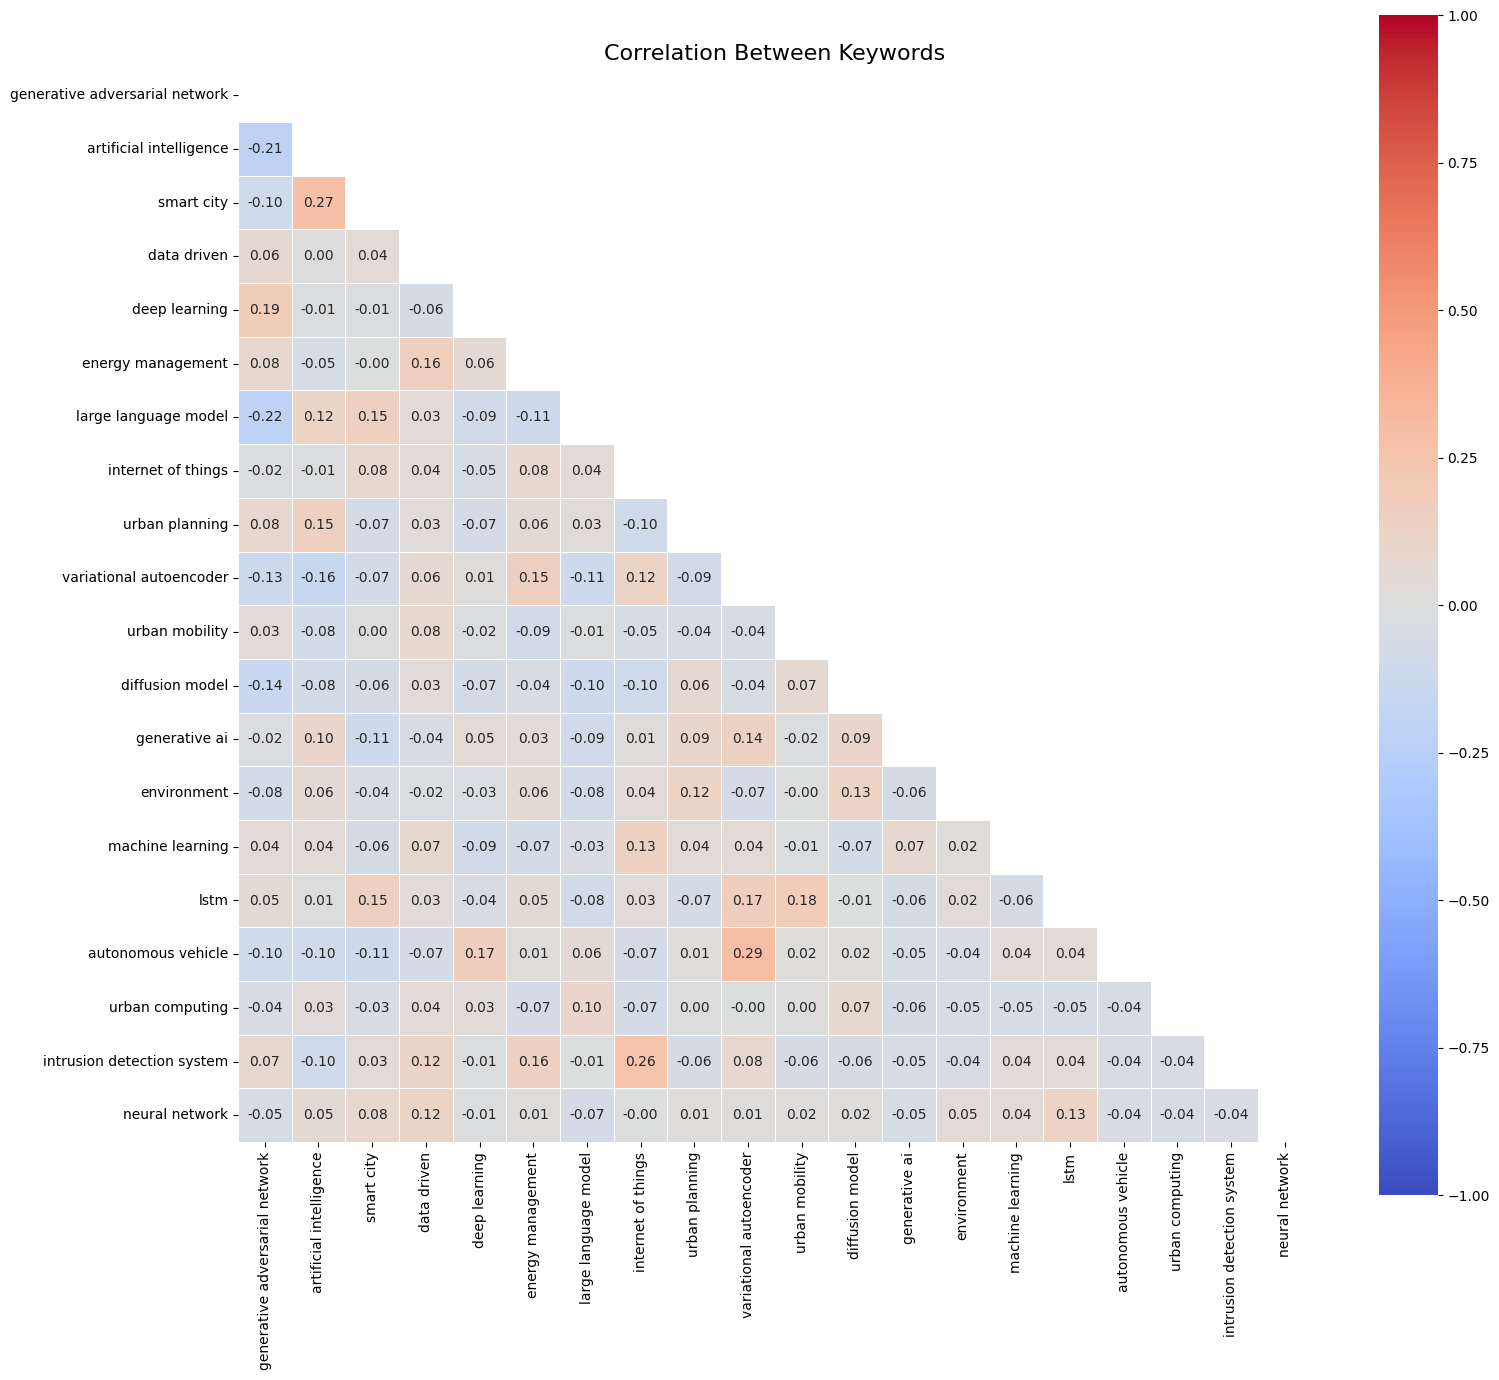

In [ ]:
# 4. Correlation Matrix Visualization
# Focus on top 20 keywords for better visualization
top20_keywords = [kw for kw, _ in keyword_counts.most_common(20)]
correlation_matrix = doc_keyword_matrix[top20_keywords].corr()

# Set up the correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    mask=mask,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
)
plt.title("Correlation Between Keywords", fontsize=16)
plt.tight_layout()
plt.show()

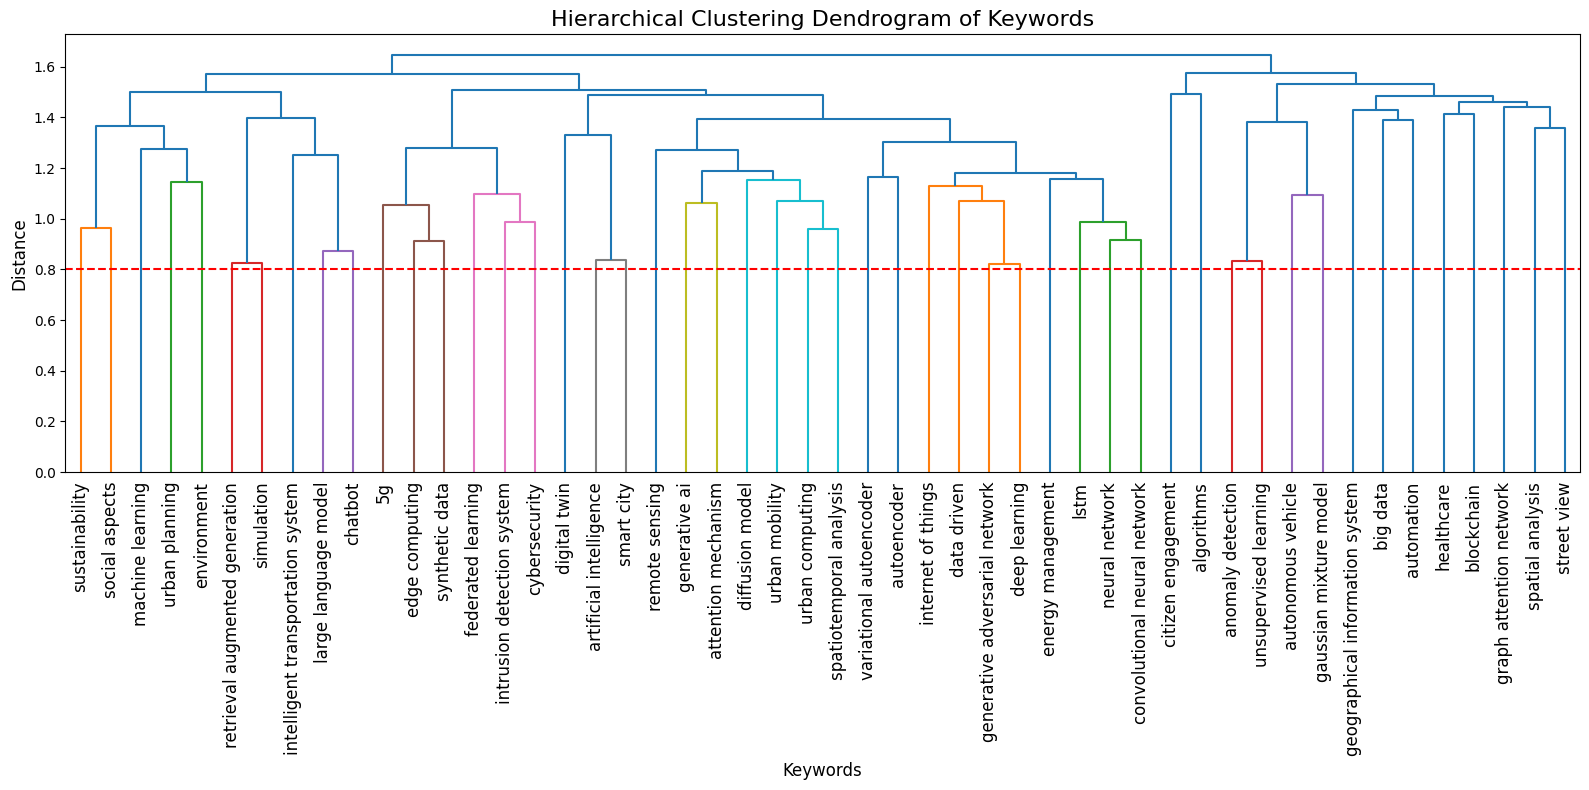


Semantic Keyword Clusters (based on article context):

Cluster 1:
urban planning, environment, machine learning, sustainability, social aspects

Cluster 2:
large language model, chatbot, intelligent transportation system, retrieval augmented generation, simulation

Cluster 3:
intrusion detection system, edge computing, federated learning, synthetic data, cybersecurity, 5g

Cluster 4:
artificial intelligence, smart city, digital twin

Cluster 5:
generative adversarial network, data driven, deep learning, energy management, internet of things, variational autoencoder, urban mobility, diffusion model, generative ai, lstm, urban computing, neural network, convolutional neural network, spatiotemporal analysis, remote sensing, attention mechanism, autoencoder

Cluster 6:
citizen engagement

Cluster 7:
algorithms

Cluster 8:
autonomous vehicle, anomaly detection, unsupervised learning, gaussian mixture model

Cluster 9:
big data, geographical information system, automation

Cluster 10:
healt

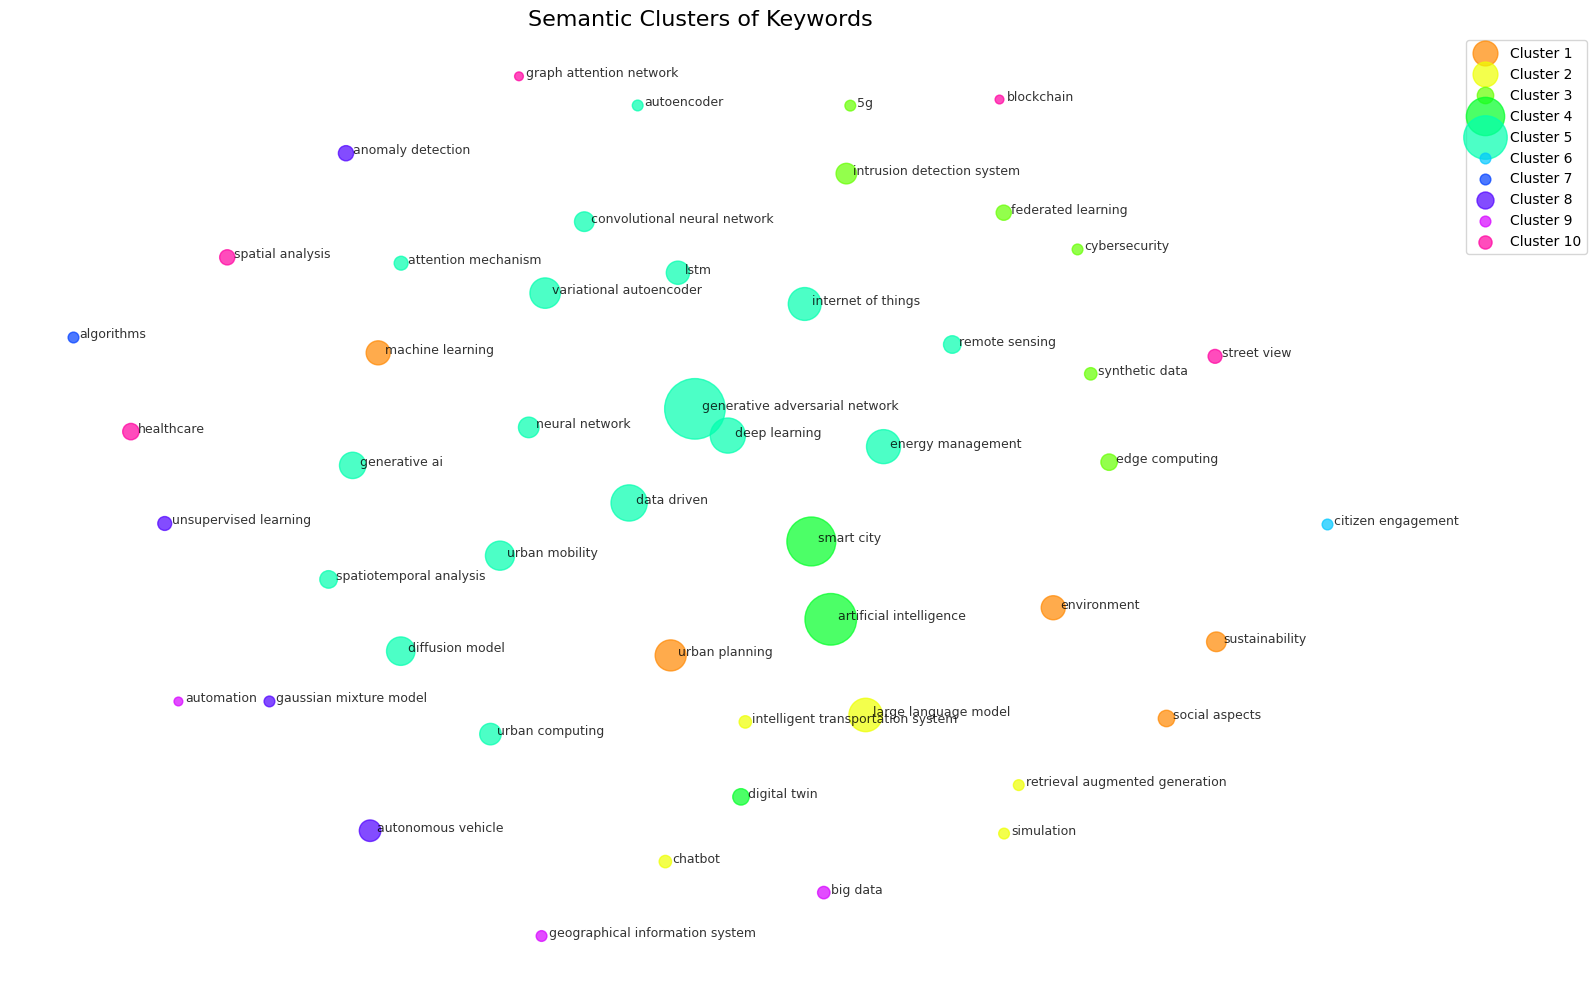



Keyword Cluster Analysis Summary:
Number of clusters: 10

Keywords per cluster:
Cluster 1: 5 keywords
Cluster 2: 5 keywords
Cluster 3: 6 keywords
Cluster 4: 3 keywords
Cluster 5: 17 keywords
Cluster 6: 1 keywords
Cluster 7: 1 keywords
Cluster 8: 4 keywords
Cluster 9: 3 keywords
Cluster 10: 5 keywords

Top keywords per cluster:
Cluster 1: urban planning, environment, machine learning
Cluster 2: large language model, chatbot, intelligent transportation system
Cluster 3: intrusion detection system, edge computing, federated learning
Cluster 4: artificial intelligence, smart city, digital twin
Cluster 5: generative adversarial network, data driven, deep learning
Cluster 6: citizen engagement
Cluster 7: algorithms
Cluster 8: autonomous vehicle, anomaly detection, unsupervised learning
Cluster 9: big data, geographical information system, automation
Cluster 10: healthcare, spatial analysis, street view

Average intra-cluster similarity:
Cluster 1: 0.28
Cluster 2: 0.26
Cluster 3: 0.28
Clust

In [ ]:
# 6. Semantic Clustering of Keywords
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import MDS

# Extract the top keywords for clustering
top_kws = [kw for kw, _ in keyword_counts.most_common(50)]

# Create vectors for each keyword based on the articles they appear in
keyword_docs = {}
for kw in top_kws:
    if kw in keyword_to_articles:
        keyword_docs[kw] = " ".join(keyword_to_articles[kw])
    else:
        keyword_docs[kw] = ""

# Vectorize the document text for each keyword
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform([keyword_docs[kw] for kw in top_kws])

# Calculate cosine similarity between keywords
similarity = cosine_similarity(X)

# Convert to a distance matrix for clustering
distance = 1 - similarity

# Perform hierarchical clustering for the dendrogram
linkage = sch.linkage(distance, method="average")

# Determine optimal number of clusters using dendrogram
plt.figure(figsize=(16, 8))
dendrogram = sch.dendrogram(linkage, labels=top_kws, leaf_font_size=12)
plt.title("Hierarchical Clustering Dendrogram of Keywords", fontsize=16)
plt.xlabel("Keywords", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.axhline(y=0.8, color="r", linestyle="--")  # Adjusted threshold for clearer clusters
plt.tight_layout()
plt.savefig("keyword_dendrogram_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

# Choose number of clusters (adjust based on dendrogram)
# num_clusters = 5  # Adjusted based on normalized keywords

# # Perform clustering with average linkage - FIXED PARAMETERS
# clustering = AgglomerativeClustering(
#     n_clusters=num_clusters,
#     metric="precomputed",
#     linkage="average",
# )
# clusters = clustering.fit_predict(distance)
# 6. Semantic Clustering of Keywords - FIXED IMPLEMENTATION
# Choose number of clusters based on dendrogram
num_clusters = 10  # Adjusted based on normalized keywords

# Use the linkage matrix we calculated earlier
clusters = fcluster(linkage, t=num_clusters, criterion="maxclust") - 1

# Create DataFrame with keywords and their clusters
cluster_df = pd.DataFrame(
    {
        "Keyword": top_kws,
        "Cluster": clusters,
        "Frequency": [keyword_counts[kw] for kw in top_kws],
    }
)

# Print the clusters
print("\nSemantic Keyword Clusters (based on article context):")
for i in range(num_clusters):
    cluster_keywords = cluster_df[cluster_df["Cluster"] == i].sort_values(
        "Frequency", ascending=False
    )
    print(f"\nCluster {i+1}:")
    print(", ".join(cluster_keywords["Keyword"].tolist()))

# Create a visualization of the clusters
plt.figure(figsize=(16, 10))

# Set up a color palette for clusters
palette = sns.color_palette("hsv", num_clusters)

# Create a scatter plot for clusters (using MDS for 2D representation)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
positions = mds.fit_transform(distance)

# Plot each cluster
for i in range(num_clusters):
    cluster_mask = clusters == i
    plt.scatter(
        positions[cluster_mask, 0],
        positions[cluster_mask, 1],
        s=[keyword_counts[kw] * 20 for kw in np.array(top_kws)[cluster_mask]],
        c=[palette[i]],
        label=f"Cluster {i+1}",
        alpha=0.7,
    )

# Add labels for each keyword
for i, (keyword, x, y) in enumerate(zip(top_kws, positions[:, 0], positions[:, 1])):
    plt.annotate(
        keyword,
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        fontsize=9,
        alpha=0.8,
    )

plt.title("Semantic Clusters of Keywords", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.axis("off")
plt.tight_layout()
plt.savefig("keyword_semantic_clusters_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

# 7. Cluster analysis summary
print("\n\nKeyword Cluster Analysis Summary:")
print(f"Number of clusters: {num_clusters}")

# Count keywords per cluster
cluster_sizes = cluster_df.groupby("Cluster").size().reset_index(name="Count")
print("\nKeywords per cluster:")
for _, row in cluster_sizes.iterrows():
    print(f"Cluster {row['Cluster']+1}: {row['Count']} keywords")

# Get representative keywords for each cluster (top 3 by frequency)
print("\nTop keywords per cluster:")
for i in range(num_clusters):
    top3 = (
        cluster_df[cluster_df["Cluster"] == i]
        .sort_values("Frequency", ascending=False)
        .head(3)
    )
    print(f"Cluster {i+1}: {', '.join(top3['Keyword'].tolist())}")

# Calculate intra-cluster similarity
intra_cluster_sim = []
for i in range(num_clusters):
    cluster_mask = clusters == i
    cluster_indices = np.where(cluster_mask)[0]
    if len(cluster_indices) > 1:
        cluster_sim = 0
        count = 0
        for idx1, idx2 in combinations(cluster_indices, 2):
            cluster_sim += similarity[idx1, idx2]
            count += 1
        if count > 0:
            intra_cluster_sim.append(cluster_sim / count)
        else:
            intra_cluster_sim.append(0)
    else:
        intra_cluster_sim.append(1)

print("\nAverage intra-cluster similarity:")
for i, sim in enumerate(intra_cluster_sim):
    print(f"Cluster {i+1}: {sim:.2f}")

print(
    f"\nOverall average intra-cluster similarity: {sum(intra_cluster_sim)/len(intra_cluster_sim):.2f}"
)

# Suggest cluster themes based on keywords
print("\nSuggested themes for each cluster:")
for i in range(num_clusters):
    cluster_kws = (
        cluster_df[cluster_df["Cluster"] == i]
        .sort_values("Frequency", ascending=False)["Keyword"]
        .tolist()
    )
    top5_kws = cluster_kws[:5]
    print(f"Cluster {i+1}: {', '.join(top5_kws)}")


Analyzing keyword mentions in abstracts...

Top 15 keywords that appear more in abstracts than as author keywords:
             Keyword  Author Keywords Count  Abstract Mentions  Difference
13       environment                     15                 55          40
56          security                      2                 34          32
42        algorithms                      3                 31          28
44        simulation                      3                 28          25
46       autoencoder                      3                 28          25
4      deep learning                     32                 43          11
19    neural network                     11                 21          10
14  machine learning                     15                 24           9
26        healthcare                      7                 16           9
55           chatgpt                      2                 10           8
65   computer vision                      2                

<Figure size 1400x1000 with 0 Axes>

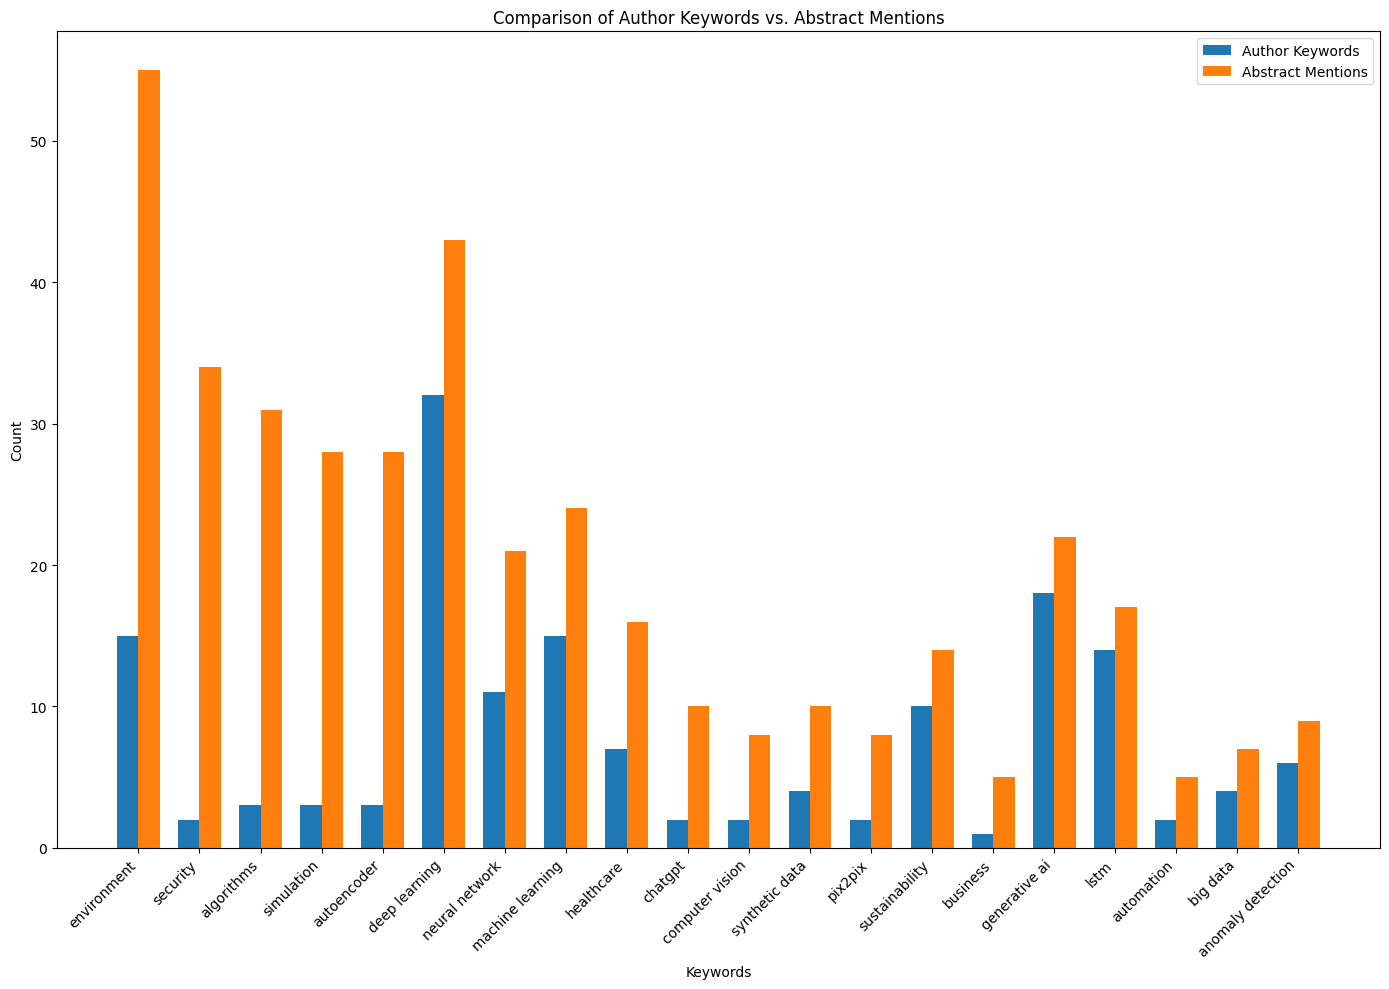


Performing semantic clustering of abstracts based on keywords...


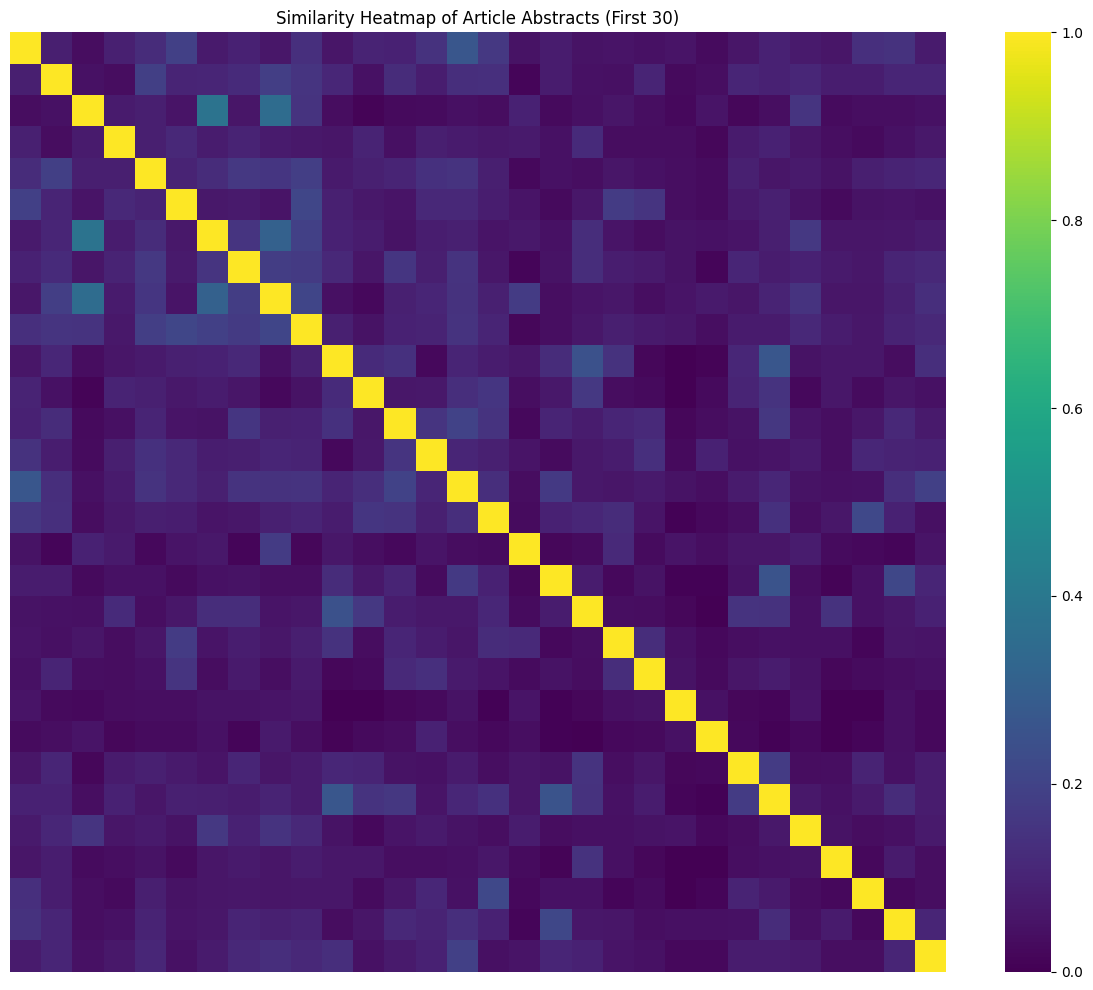

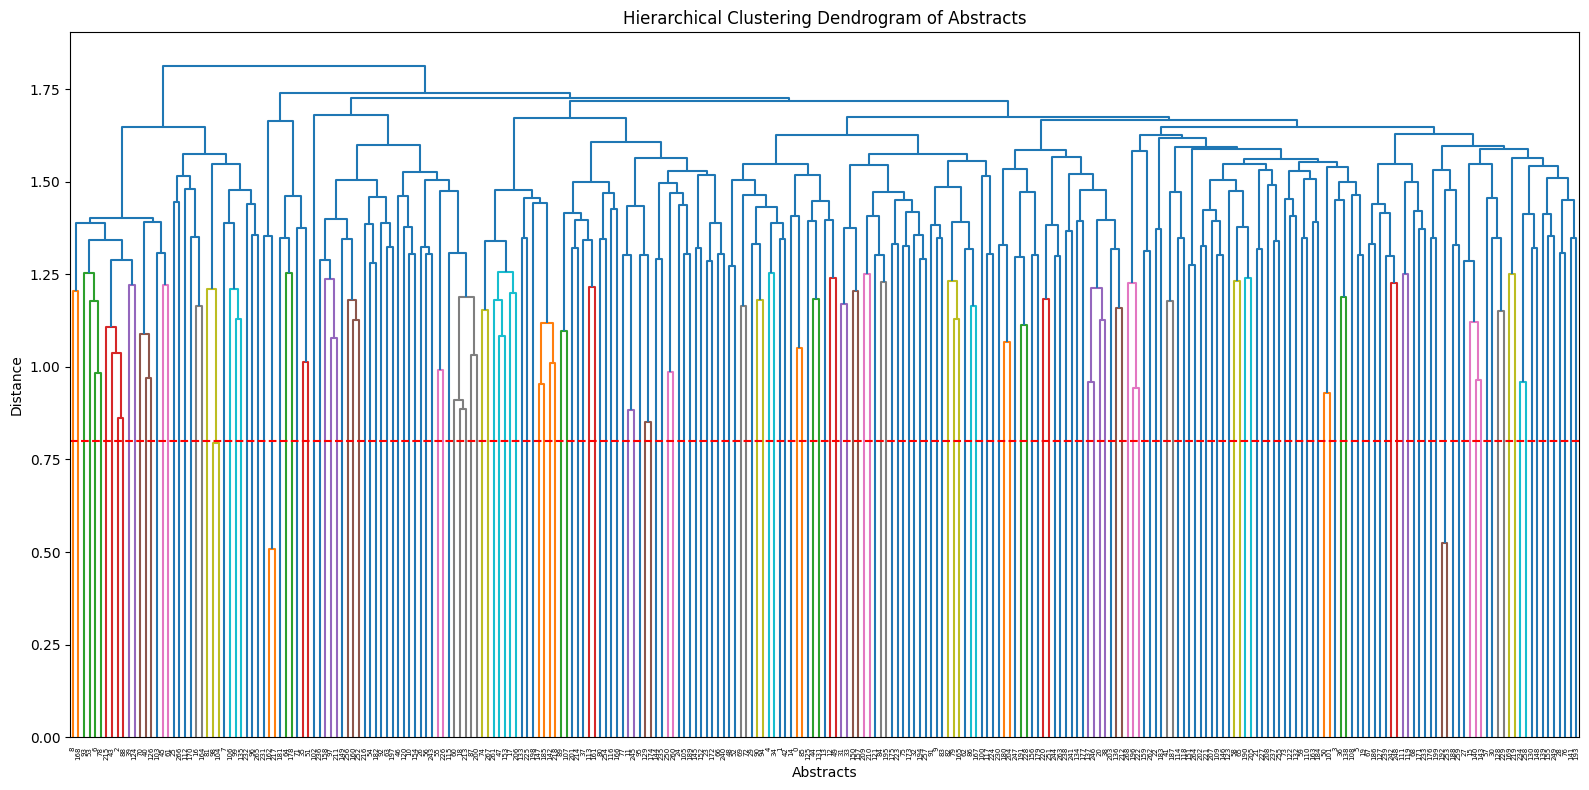


Top keywords for each abstract cluster:

Cluster 1:
Number of articles: 34
Top keywords: artificial intelligence (20), smart city (15), generative ai (11), chatgpt (7), internet of things (6), environment (6), sustainability (5), simulation (5), machine learning (4), algorithms (4)

Cluster 2:
Number of articles: 9
Top keywords: smart city (4), energy management (3), security (3), deep learning (3), environment (3), machine learning (3), simulation (3), intrusion detection system (2), digital twin (2), algorithms (2)

Cluster 3:
Number of articles: 29
Top keywords: internet of things (14), security (13), deep learning (12), autoencoder (9), anomaly detection (8), variational autoencoder (7), intrusion detection system (6), smart city (6), healthcare (5), environment (5)

Cluster 4:
Number of articles: 1
Top keywords: internet of things (1), healthcare (1), image fusion (1), security (1)

Cluster 5:
Number of articles: 14
Top keywords: generative adversarial network (6), diffusion mode

In [ ]:
# 8. Analyze Keywords in Article Abstracts
import re
from collections import defaultdict

# Track mentions of keywords in abstracts
keyword_abstract_mentions = defaultdict(int)
keyword_to_abstract_articles = defaultdict(list)

# Get top keywords for analysis
top_analysis_keywords = [kw for kw, _ in keyword_counts.most_common(100)]

print("\nAnalyzing keyword mentions in abstracts...")


# Function to check if keyword appears in text
def keyword_in_text(keyword, text):
    # Convert both to lowercase for case-insensitive matching
    if text is None or not isinstance(text, str):
        return False

    text = text.lower()
    # Create pattern to match whole words
    pattern = r"\b" + re.escape(keyword.lower()) + r"\b"
    return bool(re.search(pattern, text))


# Analyze abstracts for keyword mentions
for doc in unique_docs:
    if "abstract" in doc and doc["abstract"]:
        abstract = doc["abstract"].lower()
        title = doc["title"]

        # Check for each keyword in the abstract
        for kw in top_analysis_keywords:
            if keyword_in_text(kw, abstract):
                keyword_abstract_mentions[kw] += 1
                keyword_to_abstract_articles[kw].append(title)

# Create comparison between author keywords and abstract mentions
comparison_data = []
for kw in top_analysis_keywords:
    author_count = keyword_counts[kw] if kw in keyword_counts else 0
    abstract_count = keyword_abstract_mentions[kw]
    comparison_data.append(
        {
            "Keyword": kw,
            "Author Keywords Count": author_count,
            "Abstract Mentions": abstract_count,
            "Difference": abstract_count - author_count,
        }
    )

# Convert to DataFrame and sort by difference
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values("Difference", ascending=False)

# Display top keywords that appear more in abstracts than as author keywords
print("\nTop 15 keywords that appear more in abstracts than as author keywords:")
print(
    comparison_df.head(15)[
        ["Keyword", "Author Keywords Count", "Abstract Mentions", "Difference"]
    ]
)

# Display top keywords that appear less in abstracts than as author keywords
print("\nTop 15 keywords that appear less in abstracts than as author keywords:")
print(
    comparison_df.tail(15)[
        ["Keyword", "Author Keywords Count", "Abstract Mentions", "Difference"]
    ]
)

# Create visualization of comparison for top 20 keywords
plt.figure(figsize=(14, 10))
top20_comparison = comparison_df.iloc[:20]

# Create a grouped bar chart
x = np.arange(len(top20_comparison))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 10))
author_bars = ax.bar(
    x - width / 2,
    top20_comparison["Author Keywords Count"],
    width,
    label="Author Keywords",
)
abstract_bars = ax.bar(
    x + width / 2,
    top20_comparison["Abstract Mentions"],
    width,
    label="Abstract Mentions",
)

# Add labels and title
ax.set_xlabel("Keywords")
ax.set_ylabel("Count")
ax.set_title("Comparison of Author Keywords vs. Abstract Mentions")
ax.set_xticks(x)
ax.set_xticklabels(top20_comparison["Keyword"], rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

# 9. Semantic clustering of abstracts based on keywords
print("\nPerforming semantic clustering of abstracts based on keywords...")

# Create a document-term matrix for abstracts
docs_with_abstracts = [
    doc for doc in unique_docs if "abstract" in doc and doc["abstract"]
]
abstracts = [doc["abstract"] for doc in docs_with_abstracts]
titles = [doc["title"] for doc in docs_with_abstracts]

# Vectorize the abstracts
abstract_vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
abstract_vectors = abstract_vectorizer.fit_transform(abstracts)

# Calculate cosine similarity between abstracts
abstract_similarity = cosine_similarity(abstract_vectors)

# Create a heatmap of abstract similarities
plt.figure(figsize=(12, 10))
sns.heatmap(
    abstract_similarity[:30, :30], cmap="viridis", xticklabels=False, yticklabels=False
)
plt.title("Similarity Heatmap of Article Abstracts (First 30)")
plt.tight_layout()
plt.show()

# Use hierarchical clustering to group similar abstracts
abstract_distance = 1 - abstract_similarity
abstract_linkage = sch.linkage(abstract_distance, method="average")

# Determine optimal number of clusters
plt.figure(figsize=(16, 8))
sch.dendrogram(abstract_linkage, p=30, truncate_mode="level")
plt.title("Hierarchical Clustering Dendrogram of Abstracts")
plt.xlabel("Abstracts")
plt.ylabel("Distance")
plt.axhline(y=0.8, color="r", linestyle="--")
plt.tight_layout()
plt.show()

# Choose number of clusters for abstracts
num_abstract_clusters = 8
abstract_clusters = (
    fcluster(abstract_linkage, t=num_abstract_clusters, criterion="maxclust") - 1
)

# Analyze keyword distribution across abstract clusters
abstract_cluster_keywords = defaultdict(Counter)

for i, cluster_id in enumerate(abstract_clusters):
    abstract = abstracts[i]

    # Count keywords in this abstract
    for kw in top_analysis_keywords:
        if keyword_in_text(kw, abstract):
            abstract_cluster_keywords[cluster_id][kw] += 1

# Print top keywords for each abstract cluster
print("\nTop keywords for each abstract cluster:")
for cluster_id in range(num_abstract_clusters):
    print(f"\nCluster {cluster_id+1}:")
    cluster_size = sum(1 for c in abstract_clusters if c == cluster_id)
    print(f"Number of articles: {cluster_size}")

    # Get top keywords
    top_kws = abstract_cluster_keywords[cluster_id].most_common(10)
    if top_kws:
        print(
            "Top keywords: " + ", ".join([f"{kw} ({count})" for kw, count in top_kws])
        )
    else:
        print("No frequent keywords found.")

# Create a DataFrame with article titles and their clusters
abstract_cluster_df = pd.DataFrame({"Title": titles, "Cluster": abstract_clusters})

# Save to CSV for later reference
abstract_cluster_df.to_csv("abstract_clusters.csv", index=False)
print("\nAbstract clusters saved to 'abstract_clusters.csv'")

<Figure size 1600x1200 with 0 Axes>

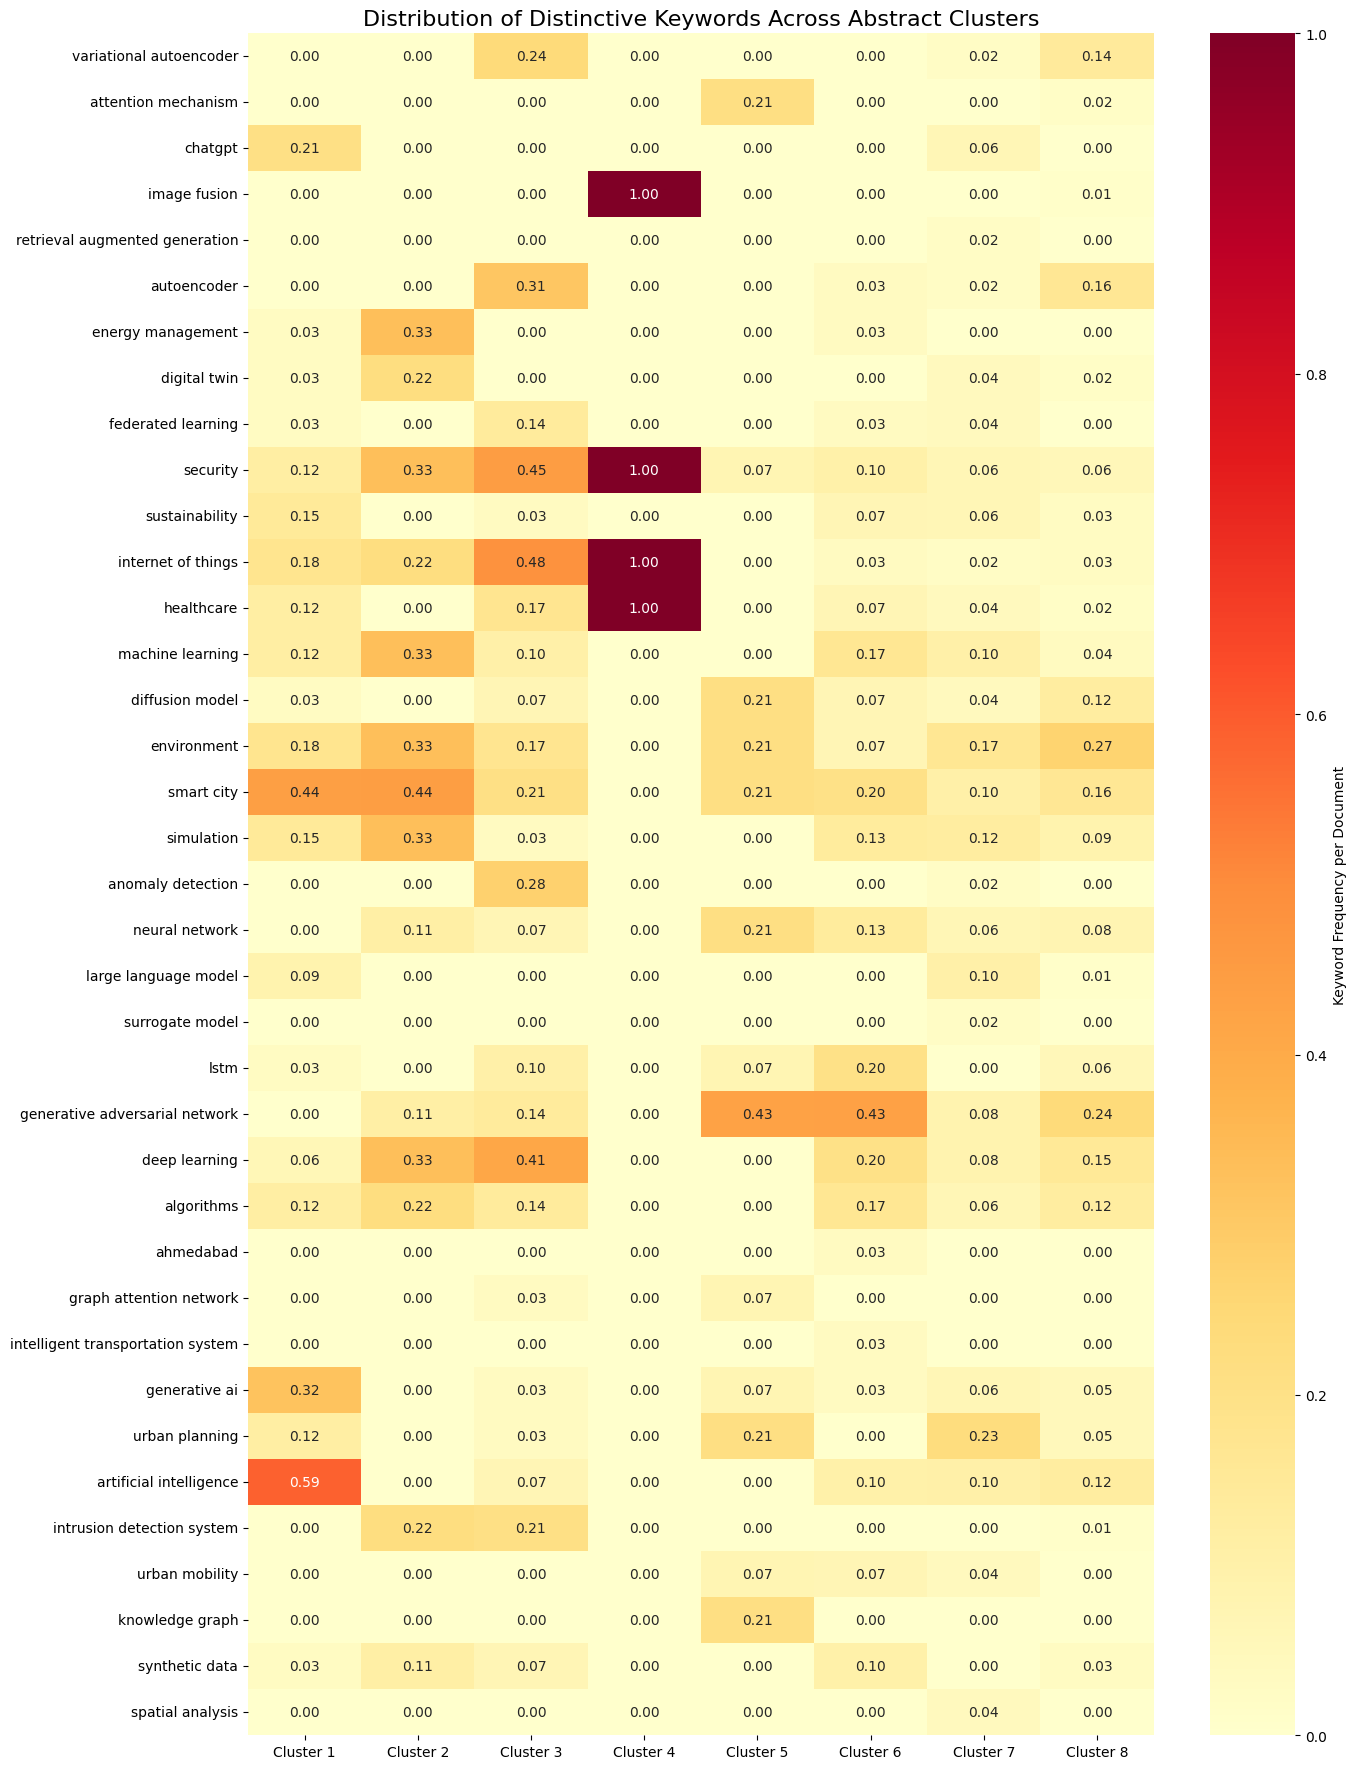

ModuleNotFoundError: No module named 'matplotlib.spokes'

In [ ]:
# 10. Enhanced Visual Analysis of Keywords in Abstract Clusters

# Create a visualization to show the relationship between abstract clusters and keywords
plt.figure(figsize=(16, 12))

# Get the most distinctive keywords for each cluster
distinctive_keywords = {}
keyword_importance = {}

# For each cluster, calculate the importance of each keyword
for cluster_id in range(num_abstract_clusters):
    cluster_size = sum(1 for c in abstract_clusters if c == cluster_id)
    keyword_importance[cluster_id] = {}

    for kw in top_analysis_keywords:
        # How many times this keyword appears in this cluster
        cluster_count = abstract_cluster_keywords[cluster_id].get(kw, 0)

        # Skip keywords that don't appear in this cluster
        if cluster_count == 0:
            continue

        # Calculate the distinctiveness of the keyword for this cluster
        # (frequency in this cluster / cluster size) / (total freq across all clusters / total docs)
        kw_in_all_clusters = sum(
            abstract_cluster_keywords[c].get(kw, 0)
            for c in range(num_abstract_clusters)
        )
        if kw_in_all_clusters > 0:
            distinctiveness = (cluster_count / cluster_size) / (
                kw_in_all_clusters / len(abstracts)
            )
            keyword_importance[cluster_id][kw] = distinctiveness * cluster_count

    # Get the top distinctive keywords for this cluster
    if keyword_importance[cluster_id]:
        distinctive_keywords[cluster_id] = sorted(
            keyword_importance[cluster_id].items(), key=lambda x: x[1], reverse=True
        )[
            :8
        ]  # Get top 8 distinctive keywords

# Create a heatmap showing the distribution of distinctive keywords across clusters
# First, collect all distinctive keywords
all_distinctive = set()
for cluster_id in distinctive_keywords:
    all_distinctive.update([kw for kw, _ in distinctive_keywords[cluster_id]])
all_distinctive = list(all_distinctive)

# Create a matrix for the heatmap
heatmap_data = np.zeros((len(all_distinctive), num_abstract_clusters))
for i, kw in enumerate(all_distinctive):
    for cluster_id in range(num_abstract_clusters):
        cluster_size = sum(1 for c in abstract_clusters if c == cluster_id)
        if cluster_size > 0:
            kw_count = abstract_cluster_keywords[cluster_id].get(kw, 0)
            heatmap_data[i, cluster_id] = kw_count / cluster_size

# Create the heatmap
plt.figure(figsize=(14, len(all_distinctive) * 0.4 + 3))
ax = sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    annot=True,
    fmt=".2f",
    yticklabels=all_distinctive,
    xticklabels=[f"Cluster {i+1}" for i in range(num_abstract_clusters)],
    cbar_kws={"label": "Keyword Frequency per Document"},
)
plt.title("Distribution of Distinctive Keywords Across Abstract Clusters", fontsize=16)
plt.tight_layout()
plt.savefig("keyword_cluster_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Create a radar chart for each cluster showing its keyword profile
# Prepare data for radar charts
from matplotlib.path import Path
from matplotlib.spokes import Spoke
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame="circle"):
    """Create a radar chart with `num_vars` axes."""
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = "radar"

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location("N")

        def fill(self, *args, **kwargs):
            return super().fill_between(theta, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(theta, *args, **kwargs)
            return lines

    register_projection(RadarAxes)
    return theta


# Create radar chart visualization to compare clusters
fig = plt.figure(figsize=(18, 14))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Select the top keywords across all clusters for comparison
top_radar_keywords = []
for cluster_id in range(num_abstract_clusters):
    if cluster_id in distinctive_keywords:
        top_radar_keywords.extend(
            [kw for kw, _ in distinctive_keywords[cluster_id][:5]]
        )

top_radar_keywords = list(set(top_radar_keywords))[
    :15
]  # Limit to 15 keywords for readability

# Create the radar chart
theta = radar_factory(len(top_radar_keywords))
colors = plt.cm.viridis(np.linspace(0, 1, num_abstract_clusters))

for i, cluster_id in enumerate(range(num_abstract_clusters)):
    ax = fig.add_subplot(3, 3, i + 1, projection="radar")

    # Get frequencies for this cluster
    cluster_size = sum(1 for c in abstract_clusters if c == cluster_id)
    if cluster_size > 0:
        values = []
        for kw in top_radar_keywords:
            count = abstract_cluster_keywords[cluster_id].get(kw, 0)
            freq = count / cluster_size if count > 0 else 0
            values.append(freq)

        # Plot the radar chart
        ax.plot(theta, values, color=colors[i])
        ax.fill(theta, values, alpha=0.25, color=colors[i])
        ax.set_title(f"Cluster {cluster_id+1} ({cluster_size} docs)", weight="bold")
        ax.set_yticklabels([])

        # Add labels
        ax.set_xticks(theta)
        ax.set_xticklabels(top_radar_keywords, fontsize=8)

plt.tight_layout()
plt.savefig("abstract_cluster_radar_charts.png", dpi=300, bbox_inches="tight")
plt.show()

# Create a chord diagram to show relationships between top keywords and clusters
# First, create a matrix showing connections between keywords and clusters
import matplotlib.pyplot as plt
import numpy as np

top_chord_keywords = list(
    set([kw for cluster in distinctive_keywords.values() for kw, _ in cluster[:3]])
)[:12]
matrix = np.zeros((len(top_chord_keywords), num_abstract_clusters))

for i, kw in enumerate(top_chord_keywords):
    for j in range(num_abstract_clusters):
        matrix[i, j] = abstract_cluster_keywords[j].get(kw, 0)

# Normalize by cluster size
for j in range(num_abstract_clusters):
    cluster_size = sum(1 for c in abstract_clusters if c == cluster_id)
    if cluster_size > 0:
        matrix[:, j] = matrix[:, j] / cluster_size

# Create a bubble chart showing keyword-cluster relationships
plt.figure(figsize=(18, 10))

# Create a grid for positioning bubbles
x_positions = np.arange(num_abstract_clusters)
y_positions = np.arange(len(top_chord_keywords))
X, Y = np.meshgrid(x_positions, y_positions)

# Create bubble sizes proportional to the normalized matrix values
sizes = matrix * 1000  # Scale for visibility

# Create the bubble chart
plt.scatter(
    X.flatten(),
    Y.flatten(),
    s=sizes.flatten(),
    alpha=0.6,
    cmap="viridis",
    c=np.repeat(np.arange(num_abstract_clusters), len(top_chord_keywords)),
)

# Add labels
plt.xticks(x_positions, [f"Cluster {i+1}" for i in range(num_abstract_clusters)])
plt.yticks(y_positions, top_chord_keywords)
plt.title("Relationship Between Key Keywords and Abstract Clusters", fontsize=16)
plt.colorbar(label="Cluster ID")
plt.grid(False)
plt.tight_layout()
plt.savefig("keyword_cluster_bubble_chart.png", dpi=300, bbox_inches="tight")
plt.show()